In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from astropy.time import Time
from scipy.interpolate import interp1d
import math
import copy
import glob
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_preparation_time import get_date_from_meteo_file, read_single_meteo_file, split_series, fill_missing_values, prepare_learning_sets, simple_data_preparation_meteo
from lstm import create_lstm_one_layer, create_lstm_two_layers

In [2]:
meteo_data = simple_data_preparation_meteo(data_dir = r'C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data', 
                     meteo_dir='meteo_CATS',meteo_tag='meteo_cats_*.csv',
                     sampling_rate_min=5,interpolate=True)

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-02-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-02-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-03-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-03-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-03-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-03-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-03-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-04-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-04-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-04-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-04-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-05-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-05-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-05-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-05-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-05-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-06-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-06-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-06-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-06-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-06-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-06-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-06-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-07-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-07-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-07-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-07-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-08-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-08-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-08-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-08-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-08-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-08-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-08-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-09-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-09-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-10-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-10-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-10-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-10-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-10-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-10-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-11-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-11-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-11-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-11-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-11-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-12-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-12-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-12-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-12-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-12-2015.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-01-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-01-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-01-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-01-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-01-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-02-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-02-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-03-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-03-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-04-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-04-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-04-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-04-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-04-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-04-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-04-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-05-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-05-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-05-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-05-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-05-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-05-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-06-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-06-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-06-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-06-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-06-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-06-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-07-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-07-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-07-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-07-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-07-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-08-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-08-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-08-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-08-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-08-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-09-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-09-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-09-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-09-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-09-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-09-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-10-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-10-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-10-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-10-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-10-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-10-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-11-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-11-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-11-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-11-2016.csv


c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-11-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-11-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-11-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-12-2016.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-01-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-01-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-02-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-02-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-02-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-03-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-03-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-03-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-03-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-04-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-04-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-04-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-04-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-04-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-05-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-06-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-06-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-06-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-07-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-07-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-07-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-07-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-07-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-07-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-07-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-08-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-08-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-08-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-08-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-08-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-08-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-09-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-09-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-09-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-09-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-09-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-09-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-10-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-10-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-10-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-10-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-10-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-11-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-11-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-11-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-11-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-12-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-12-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-12-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-12-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-12-2017.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-12-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-01-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-01-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-01-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-01-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-01-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-01-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-02-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-02-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-02-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-02-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-02-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too sma

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-02-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-03-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-03-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-03-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-03-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-03-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-04-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-04-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-04-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-04-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-05-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-05-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-05-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-05-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-06-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-06-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-06-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-06-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-06-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-06-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-06-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-07-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-07-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-07-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-07-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-07-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-07-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-07-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-08-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-08-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-08-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-08-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-08-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-08-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-09-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-09-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-09-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-09-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-09-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-10-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-10-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-10-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-10-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-10-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-11-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-11-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-11-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-11-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-11-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-11-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-12-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-12-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-12-2018.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-12-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-01-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-01-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-01-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-01-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-01-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-01-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-02-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-02-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-02-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-02-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-02-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-02-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-03-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-03-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-04-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-05-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-05-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-06-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-06-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-07-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-08-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-08-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-09-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-10-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-11-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-11-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-12-2019.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-01-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-01-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-01-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-01-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-01-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-01-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-01-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-02-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-02-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-03-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-03-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-04-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-05-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-05-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-05-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-05-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-05-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-05-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-05-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-06-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-06-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-06-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-06-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-06-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-06-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-06-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-06-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-06-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-07-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-07-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-08-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_31-08-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_02-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_03-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360


Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-09-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_26-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_01-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\for

c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-10-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-10-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_20-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_21-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_22-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_23-10-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_24-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_25-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_27-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_28-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_29-10-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_30-10-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_04-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_05-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_06-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_07-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_08-11-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_09-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_10-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_11-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_12-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_13-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_14-11-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_15-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_16-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_17-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_18-11-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\github\forecast\test_data/meteo_CATS\meteo_cats_19-11-2020.csv


c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir']==-9999] = np.nan
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:669: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['windDir'][df['windDir'] > 300] = df['windDir'][df['windDir'] > 300] - 360
c:\Users\Mary-\Desktop\PhD\First year\github\forecast\data_preparation_time.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [3]:
meteo_data

,pressure,Temperature,Humidity,windSpeed,windDir,groups,Day sin,Day cos,Year sin,Year cos
Date,,,,,,,,,,
2015-01-01 00:00:00,1021.766370,10.722222,47.0,0.000000,NaN,0,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 00:05:00,1021.631269,10.722222,47.0,0.000000,NaN,0,2.181489e-02,0.999762,0.001565,0.999999
2015-01-01 00:10:00,1021.631269,10.722222,47.0,0.000000,NaN,0,4.361939e-02,0.999048,0.001625,0.999999
2015-01-01 00:15:00,1021.631269,10.722222,47.0,0.000000,NaN,0,6.540313e-02,0.997859,0.001684,0.999999
2015-01-01 00:20:00,1021.631269,10.722222,47.0,0.000000,NaN,0,8.715574e-02,0.996195,0.001744,0.999998
...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00,884.260574,11.188889,29.0,3.460868,298.851129,63,-1.674314e-12,1.000000,-0.666004,0.745948
2020-11-19 00:05:00,884.252894,11.244444,28.0,3.222925,291.321231,63,2.181489e-02,0.999762,-0.665959,0.745988
2020-11-19 00:10:00,884.481590,11.411111,28.0,2.110863,281.611996,63,4.361939e-02,0.999048,-0.665915,0.746028


In [33]:
#count_nan = meteo_data['windDir'].isnull().sum()
#print ('Count of NaN: ' + str(count_nan))

Count of NaN: 13618


In [3]:
meteo_data = meteo_data.drop(['windSpeed', 'windDir'], axis=1)
meteo_data

,pressure,Temperature,Humidity,groups,Day sin,Day cos,Year sin,Year cos
Date,,,,,,,,
2015-01-01 00:00:00,1021.766370,10.722222,47.0,0,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 00:05:00,1021.631269,10.722222,47.0,0,2.181489e-02,0.999762,0.001565,0.999999
2015-01-01 00:10:00,1021.631269,10.722222,47.0,0,4.361939e-02,0.999048,0.001625,0.999999
2015-01-01 00:15:00,1021.631269,10.722222,47.0,0,6.540313e-02,0.997859,0.001684,0.999999
2015-01-01 00:20:00,1021.631269,10.722222,47.0,0,8.715574e-02,0.996195,0.001744,0.999998
...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00,884.260574,11.188889,29.0,63,-1.674314e-12,1.000000,-0.666004,0.745948
2020-11-19 00:05:00,884.252894,11.244444,28.0,63,2.181489e-02,0.999762,-0.665959,0.745988
2020-11-19 00:10:00,884.481590,11.411111,28.0,63,4.361939e-02,0.999048,-0.665915,0.746028


In [4]:
X_train, Y_train, X_test, Y_test,out_scaler =  prepare_learning_sets(meteo_data,input_sequence_length_min=60,
                          output_sequence_length_min=30,test_size=0.2,
                          sampling_rate_min=5, 
                          out_column='Temperature',
                          return_scaler = True)

In [5]:
model1 = create_lstm_one_layer(X_train.shape[1],X_train.shape[2],Y_train.shape[1],Y_train.shape[2],n_hidden=100)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 8)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        43600       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 6, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [6]:
# compile the keras model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae'])
#model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#              loss=tf.keras.losses.BinaryCrossentropy(),
#              metrics=['mae'])

In [7]:
history = model1.fit(X_train,Y_train,batch_size=32,epochs=20)

Epoch 1/20
14287/14287 [==============================] - 124s 8ms/step - loss: -0.0850 - mae: 0.6077
Epoch 2/20
14287/14287 [==============================] - 117s 8ms/step - loss: -0.0992 - mae: 0.4538
Epoch 3/20
14287/14287 [==============================] - 116s 8ms/step - loss: -0.1001 - mae: 0.4366
Epoch 4/20
14287/14287 [==============================] - 120s 8ms/step - loss: -0.1003 - mae: 0.4554
Epoch 5/20
14287/14287 [==============================] - 132s 9ms/step - loss: -0.1014 - mae: 0.4426
Epoch 6/20
14287/14287 [==============================] - 134s 9ms/step - loss: -0.1018 - mae: 0.4337
Epoch 7/20
14287/14287 [==============================] - 128s 9ms/step - loss: -0.1022 - mae: 0.4676
Epoch 8/20
14287/14287 [==============================] - 134s 9ms/step - loss: -0.1023 - mae: 0.5721
Epoch 9/20
14287/14287 [==============================] - 138s 10ms/step - loss: -0.1025 - mae: 0.7655
Epoch 10/20
14287/14287 [==============================] - 140s 10ms/step - loss:

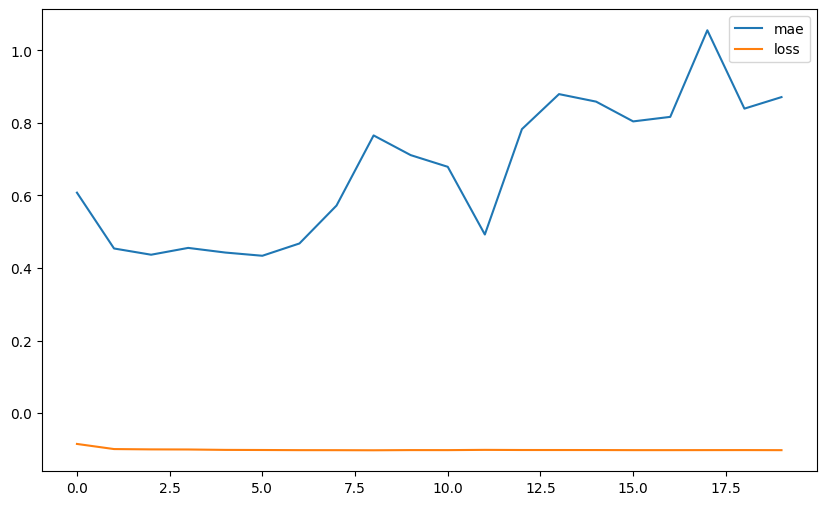

In [8]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()